## Multivariate decision tree for ligand activity classification

This notebook demonstrates how we screened all possible combinations of three descriptors for ligand activity classification using a multivariate decision tree. This was the final model used to determine ligand activity.

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Load data
df = pd.read_csv("../../data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["buchwald-type"] == 1].reset_index(drop=True)
df.fillna(0, inplace=True)

# Define bins and labels
activity_cutoff = 15
bins = [-np.inf, activity_cutoff, np.inf]
labels = [0, 1]
transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={"bins": bins, "labels": labels, "retbins": False})

# Standardize features
X = df.drop(columns=["ligand_1_name", "product_1_yield", "buchwald-type"])

# Transform target
y = df["product_1_yield"]
y_bin = transformer.fit_transform(y)

In [3]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold

preds_dict = {}


def evaluate_model_5x2(clf, X, y_bin):
    """Evaluate a binary classifier with 5×2-fold stratified cross-validation."""
    cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=2, random_state=0)

    mcc, f1, pr_auc = [], [], []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y_bin), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_bin[train_idx], y_bin[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        mcc.append(metrics.matthews_corrcoef(y_test, y_pred))
        f1.append(metrics.f1_score(y_test, y_pred, average="binary", pos_label=1))
        pr_auc.append(metrics.average_precision_score(y_test, y_prob))

    return np.mean(mcc), np.mean(f1), np.mean(pr_auc)

In [4]:
from sklearn.tree import DecisionTreeClassifier


def evaluate_features(features: list[str], n_depth: int) -> None:
    """Evaluate the model with specified features."""
    data = X[list(features)]
    clf = DecisionTreeClassifier(random_state=0, max_depth=n_depth, class_weight="balanced")

    return features, *evaluate_model_5x2(clf, data, y_bin)

In [5]:
from itertools import combinations

from joblib import Parallel, delayed
from tqdm import tqdm

run = True

n_depth = 1
combinations_list = list(combinations(X.columns, n_depth))

print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(delayed(evaluate_features)(features, n_depth) for features in tqdm(combinations_list))

    results = sorted(results, key=lambda x: x[1], reverse=True)
    # Compute the longest feature-string so we can pad everything to that width
    feat_width = max(len(", ".join(f)) for f, *_ in results) + 2  # +2 for legibility

    print()
    print(f"{'Features':<{feat_width}}  {'MCC':>5} {'PR-AUC':>5}")
    print("-" * (feat_width + 31))  # underline

    for features, mcc, f1, pr_auc in results[:10]:
        feat_str = ", ".join(features)
        print(f"{feat_str:<{feat_width}}  " f"{mcc:6.3f}  " f"{pr_auc:6.3f}")

Number of combinations: 148


100%|██████████| 148/148 [00:03<00:00, 41.65it/s]



Features                                         MCC PR-AUC
----------------------------------------------------------------------------
max_sasa_ligand_area                            0.692   0.539
max_buried_volume_5.0A                          0.496   0.326
max_P_int_ligand                                0.450   0.289
max_buried_volume_3.5A                          0.417   0.271
min_sterimol_ligand_B1                          0.347   0.222
max_quadrant_total_volume_ligand_min            0.334   0.223
buried_volume_5.0A                              0.331   0.217
quadrant_total_volume_ligand_min                0.331   0.219
max_quadrant_total_volume_ligand_max            0.317   0.220
min_homo_lumo                                   0.302   0.201


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

X_feat = X[list(results[0][0])]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=1,
)

clf.fit(X_feat, y_bin)
cv5x2_results = evaluate_features(X_feat.columns, n_depth)

print(f"Best features: {', '.join(cv5x2_results[0])}")
print(f"Train MCC: {metrics.matthews_corrcoef(y_bin, clf.predict(X_feat)):.3f}")
print(f"Train PR-AUC: {metrics.average_precision_score(y_bin, clf.predict_proba(X_feat)[:, 1]):.3f}")

print(f"CV5x2 Test MCC: {cv5x2_results[1]:.3f}")
print(f"CV5x2 Test PR-AUC: {cv5x2_results[3]:.3f}")


Best features: max_sasa_ligand_area
Train MCC: 0.747
Train PR-AUC: 0.600
CV5x2 Test MCC: 0.692
CV5x2 Test PR-AUC: 0.539


In [16]:
from itertools import combinations

from joblib import Parallel, delayed
from tqdm import tqdm

run = True

n_depth = 2
combinations_list = list(combinations(X.columns, n_depth))

print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(delayed(evaluate_features)(features, n_depth) for features in tqdm(combinations_list))

    results = sorted(results, key=lambda x: x[1], reverse=True)
    # Compute the longest feature-string so we can pad everything to that width
    feat_width = max(len(", ".join(f)) for f, *_ in results) + 2  # +2 for legibility

    print()
    print(f"{'Features':<{feat_width}}  {'MCC':>5} {'PR-AUC':>5}")
    print("-" * (feat_width + 31))  # underline

    for features, mcc, f1, pr_auc in results[:10]:
        feat_str = ", ".join(features)
        print(f"{feat_str:<{feat_width}}  " f"{mcc:6.3f}  " f"{pr_auc:6.3f}")

Number of combinations: 10878


100%|██████████| 10878/10878 [01:58<00:00, 92.05it/s]



Features                                                                                      MCC PR-AUC
-------------------------------------------------------------------------------------------------------------------------
fukui_f_minus_carb_oh, max_sasa_ligand_area                                                  0.821   0.729
partial_charge_metal, max_sasa_ligand_area                                                   0.793   0.676
max_buried_volume_3.5A, max_P_int_ligand                                                     0.760   0.643
buried_sterimol_ligand_L, max_sasa_ligand_area                                               0.744   0.604
max_sasa_ligand_area, max_buried_sterimol_ligand_L                                           0.744   0.604
min_fukui_f_minus_aryl_carbon, max_sasa_ligand_area                                          0.740   0.606
min_buried_sterimol_ligand_L, max_sasa_ligand_area                                           0.715   0.568
min_fukui_f_minus_amine

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

X_feat = X[list(results[0][0])]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=2,
)

clf.fit(X_feat, y_bin)
cv5x2_results = evaluate_features(X_feat.columns, n_depth)

print(f"Best features: {', '.join(cv5x2_results[0])}")
print(f"Train MCC: {metrics.matthews_corrcoef(y_bin, clf.predict(X_feat)):.3f}")
print(f"Train PR-AUC: {metrics.average_precision_score(y_bin, clf.predict_proba(X_feat)[:, 1]):.3f}")

print(f"CV5x2 Test MCC: {cv5x2_results[1]:.3f}")
print(f"CV5x2 Test PR-AUC: {cv5x2_results[3]:.3f}")


Best features: fukui_f_minus_carb_oh, max_sasa_ligand_area
Train MCC: 0.943
Train PR-AUC: 0.900
CV5x2 Test MCC: 0.821
CV5x2 Test PR-AUC: 0.729


/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


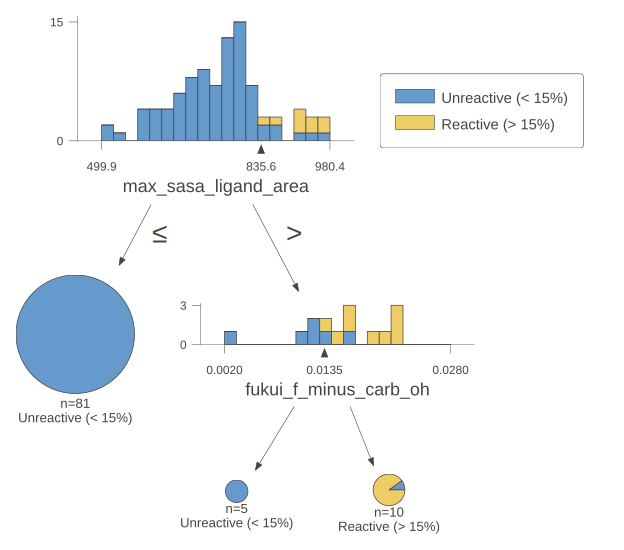

In [8]:
import dtreeviz

X_feat = X_feat.round(3)
clf.fit(X_feat, y_bin)


viz_model = dtreeviz.model(
    clf,
    X_train=X_feat,
    y_train=y_bin,
    feature_names=X_feat.columns,
    class_names=["Unreactive (< 15%)", "Reactive (> 15%)"],
)

class_colors = [
    None,  # 0 classes
    None,  # 1 class
    ["#69C", "#EC6"],  # 2 classes
]

v = viz_model.view(
    fontname="liberation sans",
    scale=2.0,
    show_root_edge_labels=True,
    colors=dict(classes=class_colors),
)

v

### Control Experiment

Y-Shuffle Control

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

print(list(results[0][0]))
X_feat = X[list(results[0][0])]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=2,
)

y_bin_shuffle = y_bin.sample(frac=1, random_state=42)
cv5x2_results = evaluate_model_5x2(clf, X_feat, y_bin_shuffle)

clf.fit(X_feat, y_bin_shuffle)
print(f"Train MCC: {metrics.matthews_corrcoef(y_bin_shuffle, clf.predict(X_feat)):.3f}")
print(f"Train PR-AUC: {metrics.average_precision_score(y_bin_shuffle, clf.predict_proba(X_feat)[:, 1]):.3f}")

print(f"CV5x2 Test MCC: {cv5x2_results[0]:.3f}")
print(f"CV5x2 Test PR-AUC: {cv5x2_results[2]:.3f}")

['fukui_f_minus_carb_oh', 'max_sasa_ligand_area']
Train MCC: 0.227
Train PR-AUC: 0.170
CV5x2 Test MCC: 0.642
CV5x2 Test PR-AUC: 0.550


X-Randomization Control

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)

run = False
X_feat = X[list(results[0][0])]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=2,
)


def generate_random_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Generate a random dataframe with the same shape and distribution as the input dataframe.

    This function ensures that each column's random data matches the original min and max values.

    Args:
        df (pd.DataFrame): DataFrame to generate random data from.

    Returns:
        pd.DataFrame: DataFrame with random data.
    """
    np.random.seed(0)
    df = df.copy()
    for col in df.columns:
        df[col] = np.random.uniform(low=df[col].min(), high=df[col].max(), size=df[col].shape)
    return df


X_feat_rand = generate_random_dataframe(X_feat)
cv5x2_results = evaluate_model_5x2(clf, X_feat_rand, y_bin)

clf.fit(X_feat_rand, y_bin)
print(f"Train MCC: {metrics.matthews_corrcoef(y_bin, clf.predict(X_feat_rand)):.3f}")
print(f"Train PR-AUC: {metrics.average_precision_score(y_bin, clf.predict_proba(X_feat_rand)[:, 1]):.3f}")

print(f"CV5x2 Test MCC: {cv5x2_results[0]:.3f}")
print(f"CV5x2 Test PR-AUC: {cv5x2_results[2]:.3f}")

Train MCC: 0.249
Train PR-AUC: 0.150
CV5x2 Test MCC: 0.035
CV5x2 Test PR-AUC: 0.106
